<a href="https://colab.research.google.com/github/Chandana0127/Retrieval-Augmented-Generation-for-NLP-Research-Papers/blob/main/Retrieval_Augmented_Generation_for_NLP_Research_Papers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Complete RAG System - Optimized for Fast Embedding Generation
import os
import json
import re
import numpy as np
import pandas as pd
from typing import List, Dict, Tuple, Optional
from dataclasses import dataclass
from collections import defaultdict
import pickle
import time
import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')

base_dir = '/content/drive/MyDrive/RAG_NLP_Project'
print(f"Working directory: {base_dir}")

print("Installing required packages...")
import subprocess
subprocess.run(['pip', 'install', '-q', 'sentence-transformers', 'rank-bm25', 'faiss-cpu', 'transformers', 'torch', 'rouge-score', 'nltk', 'accelerate'], check=False)

from sentence_transformers import SentenceTransformer
from rank_bm25 import BM25Okapi
import faiss
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, AutoModelForCausalLM
import torch
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import nltk
from tqdm.auto import tqdm

nltk.download('punkt', quiet=True)
try:
    nltk.download('punkt_tab', quiet=True)
except:
    pass

print("All imports successful!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

device = 'cuda' if torch.cuda.is_available() else 'cpu'

@dataclass
class Chunk:
    text: str
    paper_id: str
    chunk_id: int
    paper_title: str
    authors: List[str]
    abstract: str

@dataclass
class RetrievalResult:
    chunk: Chunk
    score: float
    rank: int

print("\nLoading existing data from Google Drive...")
chunks_path = f"{base_dir}/document_chunks.pkl"
with open(chunks_path, 'rb') as f:
    chunk_metadata = pickle.load(f)

chunks = []
all_chunk_texts = []
for meta in chunk_metadata:
    chunk = Chunk(
        text=meta['chunk_text'],
        paper_id=meta['paper_id'],
        chunk_id=meta['chunk_id'],
        paper_title=meta['title'],
        authors=meta['authors'],
        abstract=meta['abstract']
    )
    chunks.append(chunk)
    all_chunk_texts.append(meta['chunk_text'])

unique_papers = set([chunk.paper_id for chunk in chunks])
print(f"Loaded {len(chunks)} chunks from {len(unique_papers)} papers")

def generate_embeddings_optimized(chunks_list, model, model_name, batch_size=64):
    """Optimized embedding generation with progress bar"""
    print(f"\nGenerating {model_name} embeddings...")
    print(f"Total chunks: {len(chunks_list)}")
    print(f"Batch size: {batch_size}")

    embeddings = []

    for i in tqdm(range(0, len(chunks_list), batch_size), desc=model_name):
        batch = chunks_list[i:i + batch_size]
        with torch.no_grad():
            batch_emb = model.encode(
                batch,
                convert_to_tensor=True,
                show_progress_bar=False,
                batch_size=batch_size
            )
            embeddings.append(batch_emb.cpu().numpy())

        if device == 'cuda':
            torch.cuda.empty_cache()

    embeddings_array = np.vstack(embeddings)
    print(f"Completed! Shape: {embeddings_array.shape}")
    return embeddings_array

embeddings_dir = f"{base_dir}/embeddings"
os.makedirs(embeddings_dir, exist_ok=True)

print("\n" + "="*80)
print("GENERATING EMBEDDINGS - This will take 15-20 minutes with GPU")
print("="*80)

print("\nLoading embedding models...")
scibert_model = SentenceTransformer('allenai/scibert_scivocab_uncased').to(device)
minilm_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2').to(device)
mpnet_model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2').to(device)
instructor_model = SentenceTransformer('hkunlp/instructor-base').to(device)
print("All models loaded!")

batch_size = 64 if device == 'cuda' else 32

scibert_embeddings = generate_embeddings_optimized(all_chunk_texts, scibert_model, "SciBERT", batch_size)
np.save(f"{embeddings_dir}/scibert_embeddings.npy", scibert_embeddings)

minilm_embeddings = generate_embeddings_optimized(all_chunk_texts, minilm_model, "MiniLM", batch_size)
np.save(f"{embeddings_dir}/minilm_embeddings.npy", minilm_embeddings)

mpnet_embeddings = generate_embeddings_optimized(all_chunk_texts, mpnet_model, "MPNet", batch_size)
np.save(f"{embeddings_dir}/mpnet_embeddings.npy", mpnet_embeddings)

instructor_embeddings = generate_embeddings_optimized(all_chunk_texts, instructor_model, "Instructor", batch_size)
np.save(f"{embeddings_dir}/instructor_embeddings.npy", instructor_embeddings)

print("\n" + "="*80)
print("ALL EMBEDDINGS SAVED TO GOOGLE DRIVE!")
print("="*80)

class DenseRetriever:
    def __init__(self, embeddings: np.ndarray, chunks: List[Chunk]):
        self.chunks = chunks
        d = embeddings.shape[1]
        self.index = faiss.IndexFlatIP(d)
        normalized = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)
        self.index.add(normalized.astype('float32'))

    def search(self, query_embedding: np.ndarray, k: int = 5) -> List[RetrievalResult]:
        query_norm = query_embedding / np.linalg.norm(query_embedding)
        scores, indices = self.index.search(query_norm.reshape(1, -1).astype('float32'), k)
        results = []
        for rank, (idx, score) in enumerate(zip(indices[0], scores[0])):
            results.append(RetrievalResult(chunk=self.chunks[idx], score=float(score), rank=rank + 1))
        return results

class BM25Retriever:
    def __init__(self, chunks: List[Chunk]):
        self.chunks = chunks
        tokenized_corpus = [chunk.text.lower().split() for chunk in chunks]
        self.bm25 = BM25Okapi(tokenized_corpus)

    def search(self, query: str, k: int = 5) -> List[RetrievalResult]:
        tokenized_query = query.lower().split()
        scores = self.bm25.get_scores(tokenized_query)
        top_indices = np.argsort(scores)[::-1][:k]
        results = []
        for rank, idx in enumerate(top_indices):
            results.append(RetrievalResult(chunk=self.chunks[idx], score=float(scores[idx]), rank=rank + 1))
        return results

class HybridRetriever:
    def __init__(self, dense_retriever: DenseRetriever, bm25_retriever: BM25Retriever, alpha: float = 0.5):
        self.dense = dense_retriever
        self.bm25 = bm25_retriever
        self.alpha = alpha

    def search(self, query: str, query_embedding: np.ndarray, k: int = 5) -> List[RetrievalResult]:
        dense_results = self.dense.search(query_embedding, k=k*2)
        bm25_results = self.bm25.search(query, k=k*2)

        chunk_scores = {}
        for res in dense_results:
            chunk_id = (res.chunk.paper_id, res.chunk.chunk_id)
            chunk_scores[chunk_id] = {'chunk': res.chunk, 'dense': res.score, 'bm25': 0.0}

        for res in bm25_results:
            chunk_id = (res.chunk.paper_id, res.chunk.chunk_id)
            if chunk_id in chunk_scores:
                chunk_scores[chunk_id]['bm25'] = res.score
            else:
                chunk_scores[chunk_id] = {'chunk': res.chunk, 'dense': 0.0, 'bm25': res.score}

        for chunk_id in chunk_scores:
            dense_score = chunk_scores[chunk_id]['dense']
            bm25_score = chunk_scores[chunk_id]['bm25']
            chunk_scores[chunk_id]['hybrid'] = self.alpha * dense_score + (1 - self.alpha) * bm25_score

        sorted_chunks = sorted(chunk_scores.items(), key=lambda x: x[1]['hybrid'], reverse=True)
        results = []
        for rank, (chunk_id, data) in enumerate(sorted_chunks[:k]):
            results.append(RetrievalResult(chunk=data['chunk'], score=data['hybrid'], rank=rank + 1))
        return results

print("\nInitializing retrievers...")
print("Building BM25 index...")
bm25_retriever = BM25Retriever(chunks)

print("Building FAISS indexes...")
scibert_retriever = DenseRetriever(scibert_embeddings, chunks)
minilm_retriever = DenseRetriever(minilm_embeddings, chunks)
mpnet_retriever = DenseRetriever(mpnet_embeddings, chunks)
instructor_retriever = DenseRetriever(instructor_embeddings, chunks)

print("All retrievers initialized!")

class RAGGenerator:
    def __init__(self, model_name: str = "google/flan-t5-base"):
        print(f"Loading generation model: {model_name}")
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(device)
        self.model_name = model_name

    def generate(self, query: str, retrieved_chunks: List[RetrievalResult], max_length: int = 256) -> str:
        context = "\n\n".join([f"[{i+1}] {r.chunk.text[:300]}" for i, r in enumerate(retrieved_chunks[:3])])
        prompt = f"Question: {query}\n\nContext:\n{context}\n\nAnswer:"

        inputs = self.tokenizer(prompt, return_tensors="pt", max_length=512, truncation=True).to(device)

        with torch.no_grad():
            outputs = self.model.generate(
                **inputs,
                max_length=max_length,
                num_beams=4,
                early_stopping=True,
                no_repeat_ngram_size=3
            )

        answer = self.tokenizer.decode(outputs[0], skip_special_tokens=True)
        return answer

class Evaluator:
    def __init__(self):
        self.rouge_scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
        self.smoothing = SmoothingFunction()

    def evaluate_generation(self, generated: str, reference: str) -> Dict[str, float]:
        rouge_scores = self.rouge_scorer.score(reference, generated)

        gen_tokens = generated.lower().split()
        ref_tokens = reference.lower().split()
        bleu = sentence_bleu([ref_tokens], gen_tokens, smoothing_function=self.smoothing.method1)

        return {
            'rouge1': rouge_scores['rouge1'].fmeasure,
            'rouge2': rouge_scores['rouge2'].fmeasure,
            'rougeL': rouge_scores['rougeL'].fmeasure,
            'bleu': bleu
        }

print("\nInitializing generation models...")
flan_t5_generator = RAGGenerator("google/flan-t5-base")

print("Loading TinyLlama...")
tinyllama_tokenizer = AutoTokenizer.from_pretrained("TinyLlama/TinyLlama-1.1B-Chat-v1.0")
tinyllama_model = AutoModelForCausalLM.from_pretrained("TinyLlama/TinyLlama-1.1B-Chat-v1.0", torch_dtype=torch.float16).to(device)

evaluator = Evaluator()

test_queries = [
    "What are attention mechanisms in transformer models?",
    "How do large language models process natural language?",
    "What is retrieval augmented generation?",
    "Explain the benefits of pre-training in NLP",
    "How does BERT differ from GPT models?"
]

print("\n" + "="*80)
print("STARTING EXPERIMENTS")
print("="*80)

print("\n--- RQ1: Embedding Model Comparison ---")
embedding_models = {
    'SciBERT': (scibert_retriever, scibert_model),
    'MiniLM': (minilm_retriever, minilm_model),
    'MPNet': (mpnet_retriever, mpnet_model),
    'Instructor': (instructor_retriever, instructor_model)
}

rq1_results = []
for model_name, (retriever, encoder) in embedding_models.items():
    print(f"\nEvaluating {model_name}...")
    for query in test_queries:
        query_embedding = encoder.encode(query, convert_to_tensor=True).cpu().numpy()
        results = retriever.search(query_embedding, k=5)

        avg_score = np.mean([r.score for r in results])
        unique_papers = len(set([r.chunk.paper_id for r in results]))

        rq1_results.append({
            'Model': model_name,
            'Query': query[:50],
            'Avg_Score': avg_score,
            'Unique_Papers': unique_papers
        })

df_rq1 = pd.DataFrame(rq1_results)
print("\nRQ1 Results Summary:")
print(df_rq1.groupby('Model')[['Avg_Score', 'Unique_Papers']].mean())

print("\n--- RQ2: Hybrid Retrieval Optimization ---")
alphas = [0.0, 0.3, 0.5, 0.7, 1.0]
rq2_results = []

for alpha in alphas:
    strategy_name = f"Dense" if alpha == 1.0 else f"BM25" if alpha == 0.0 else f"Hybrid(α={alpha})"
    hybrid_retriever = HybridRetriever(scibert_retriever, bm25_retriever, alpha=alpha)

    for query in test_queries:
        query_embedding = scibert_model.encode(query, convert_to_tensor=True).cpu().numpy()
        results = hybrid_retriever.search(query, query_embedding, k=5)

        avg_score = np.mean([r.score for r in results])
        unique_papers = len(set([r.chunk.paper_id for r in results]))

        rq2_results.append({
            'Alpha': alpha,
            'Strategy': strategy_name,
            'Query': query[:50],
            'Avg_Score': avg_score,
            'Unique_Papers': unique_papers
        })

df_rq2 = pd.DataFrame(rq2_results)
print("\nRQ2 Results Summary:")
print(df_rq2.groupby('Strategy')[['Avg_Score', 'Unique_Papers']].mean())

print("\n--- RQ3: Generation Quality Comparison ---")
optimal_hybrid = HybridRetriever(scibert_retriever, bm25_retriever, alpha=0.5)
rq3_results = []

reference_answers = [
    "Attention mechanisms allow models to focus on relevant parts of the input sequence by computing weighted representations.",
    "Large language models use transformer architectures to process text through layers of attention and feed-forward networks.",
    "Retrieval augmented generation combines information retrieval with language generation to produce factually grounded responses.",
    "Pre-training helps models learn general language representations that transfer to downstream tasks.",
    "BERT uses bidirectional encoding while GPT uses unidirectional autoregressive generation."
]

for query, reference in zip(test_queries, reference_answers):
    print(f"\nProcessing: {query[:50]}...")
    query_embedding = scibert_model.encode(query, convert_to_tensor=True).cpu().numpy()
    retrieved = optimal_hybrid.search(query, query_embedding, k=5)

    flan_answer = flan_t5_generator.generate(query, retrieved, max_length=128)

    context = "\n".join([r.chunk.text[:200] for r in retrieved[:3]])
    tinyllama_prompt = f"<|system|>You are a helpful AI assistant.</s>\n<|user|>\nQuestion: {query}\n\nContext: {context}\n\nProvide a concise answer.</s>\n<|assistant|>"
    tinyllama_inputs = tinyllama_tokenizer(tinyllama_prompt, return_tensors="pt", max_length=512, truncation=True).to(device)

    with torch.no_grad():
        tinyllama_outputs = tinyllama_model.generate(**tinyllama_inputs, max_new_tokens=128, temperature=0.7, do_sample=True)
    tinyllama_answer = tinyllama_tokenizer.decode(tinyllama_outputs[0], skip_special_tokens=True)
    tinyllama_answer = tinyllama_answer.split("<|assistant|>")[-1].strip()[:500]

    flan_metrics = evaluator.evaluate_generation(flan_answer, reference)
    tinyllama_metrics = evaluator.evaluate_generation(tinyllama_answer, reference)

    rq3_results.append({
        'Model': 'Flan-T5-Base',
        'Query': query[:50],
        'ROUGE-1': flan_metrics['rouge1'],
        'ROUGE-2': flan_metrics['rouge2'],
        'BLEU': flan_metrics['bleu'],
        'Answer_Length': len(flan_answer.split())
    })

    rq3_results.append({
        'Model': 'TinyLlama-1.1B',
        'Query': query[:50],
        'ROUGE-1': tinyllama_metrics['rouge1'],
        'ROUGE-2': tinyllama_metrics['rouge2'],
        'BLEU': tinyllama_metrics['bleu'],
        'Answer_Length': len(tinyllama_answer.split())
    })

df_rq3 = pd.DataFrame(rq3_results)
print("\nRQ3 Results Summary:")
print(df_rq3.groupby('Model')[['ROUGE-1', 'ROUGE-2', 'BLEU', 'Answer_Length']].mean())

print("\n--- RQ4: FAISS Scalability Test ---")
dataset_sizes = [50, 100, 200, 350, 500]
rq4_results = []

for size in dataset_sizes:
    print(f"\nTesting with {size} papers...")
    subset_chunks = chunks[:int(len(chunks) * (size / len(unique_papers)))]
    subset_embeddings = scibert_embeddings[:len(subset_chunks)]

    start_time = time.time()
    test_retriever = DenseRetriever(subset_embeddings, subset_chunks)
    index_time = (time.time() - start_time) * 1000

    query_times = []
    for query in test_queries:
        query_embedding = scibert_model.encode(query, convert_to_tensor=True).cpu().numpy()
        start = time.time()
        test_retriever.search(query_embedding, k=5)
        query_times.append((time.time() - start) * 1000)

    rq4_results.append({
        'Num_Papers': size,
        'Num_Chunks': len(subset_chunks),
        'Indexing_Time_ms': index_time,
        'Avg_Query_Time_ms': np.mean(query_times),
        'Max_Query_Time_ms': np.max(query_times)
    })

df_rq4 = pd.DataFrame(rq4_results)
print("\nRQ4 Results Summary:")
print(df_rq4)

results_dir = f"{base_dir}/rag_results"
os.makedirs(results_dir, exist_ok=True)

df_rq1.to_csv(f"{results_dir}/rq1_embedding_comparison.csv", index=False)
df_rq2.to_csv(f"{results_dir}/rq2_hybrid_retrieval.csv", index=False)
df_rq3.to_csv(f"{results_dir}/rq3_generation_quality.csv", index=False)
df_rq4.to_csv(f"{results_dir}/rq4_scalability.csv", index=False)

print(f"\nAll results saved to: {results_dir}")

try:
    import matplotlib.pyplot as plt

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('RAG System Experimental Results', fontsize=16, fontweight='bold')

    ax1 = axes[0, 0]
    df_rq1.groupby('Model')['Avg_Score'].mean().plot(kind='bar', ax=ax1, color='skyblue')
    ax1.set_title('RQ1: Embedding Model Performance')
    ax1.set_ylabel('Average Retrieval Score')
    ax1.set_xlabel('Model')
    ax1.tick_params(axis='x', rotation=45)

    ax2 = axes[0, 1]
    df_rq2.groupby('Strategy')['Unique_Papers'].mean().plot(kind='bar', ax=ax2, color='lightgreen')
    ax2.set_title('RQ2: Retrieval Strategy Diversity')
    ax2.set_ylabel('Avg Unique Papers Retrieved')
    ax2.set_xlabel('Strategy')
    ax2.tick_params(axis='x', rotation=45)

    ax3 = axes[1, 0]
    df_rq3.groupby('Model')[['ROUGE-1', 'ROUGE-2', 'BLEU']].mean().plot(kind='bar', ax=ax3)
    ax3.set_title('RQ3: Generation Quality Metrics')
    ax3.set_ylabel('Score')
    ax3.set_xlabel('Model')
    ax3.legend(loc='best')
    ax3.tick_params(axis='x', rotation=45)

    ax4 = axes[1, 1]
    ax4.plot(df_rq4['Num_Papers'], df_rq4['Avg_Query_Time_ms'], marker='o', linewidth=2, markersize=8, color='purple')
    ax4.set_title('RQ4: FAISS Query Time Scalability')
    ax4.set_xlabel('Number of Papers')
    ax4.set_ylabel('Avg Query Time (ms)')
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f"{results_dir}/experimental_results.png", dpi=300, bbox_inches='tight')
    print(f"Visualization saved to: {results_dir}/experimental_results.png")
    plt.show()

except Exception as e:
    print(f"Could not create visualization: {str(e)}")

print("\n" + "="*80)
print("ALL EXPERIMENTS COMPLETE!")
print("="*80)
print(f"\nResults saved to: {results_dir}")
print("Files created:")
print("- rq1_embedding_comparison.csv")
print("- rq2_hybrid_retrieval.csv")
print("- rq3_generation_quality.csv")
print("- rq4_scalability.csv")
print("- experimental_results.png")

Mounted at /content/drive
Working directory: /content/drive/MyDrive/RAG_NLP_Project
Installing required packages...
All imports successful!
PyTorch version: 2.8.0+cu126
CUDA available: True
GPU: Tesla T4

Loading existing data from Google Drive...
Loaded 13283 chunks from 500 papers

GENERATING EMBEDDINGS - This will take 15-20 minutes with GPU

Loading embedding models...


config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/442M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/442M [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/461 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/439M [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/270 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/115 [00:00<?, ?B/s]

2_Dense/pytorch_model.bin:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

All models loaded!

Generating SciBERT embeddings...
Total chunks: 13283
Batch size: 64


SciBERT:   0%|          | 0/208 [00:00<?, ?it/s]

Completed! Shape: (13283, 768)

Generating MiniLM embeddings...
Total chunks: 13283
Batch size: 64


MiniLM:   0%|          | 0/208 [00:00<?, ?it/s]

Completed! Shape: (13283, 384)

Generating MPNet embeddings...
Total chunks: 13283
Batch size: 64


MPNet:   0%|          | 0/208 [00:00<?, ?it/s]

Completed! Shape: (13283, 768)

Generating Instructor embeddings...
Total chunks: 13283
Batch size: 64


Instructor:   0%|          | 0/208 [00:00<?, ?it/s]

Completed! Shape: (13283, 768)

ALL EMBEDDINGS SAVED TO GOOGLE DRIVE!

Initializing retrievers...
Building BM25 index...
Building FAISS indexes...
All retrievers initialized!

Initializing generation models...
Loading generation model: google/flan-t5-base


tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Loading TinyLlama...


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]


STARTING EXPERIMENTS

--- RQ1: Embedding Model Comparison ---

Evaluating SciBERT...

Evaluating MiniLM...

Evaluating MPNet...

Evaluating Instructor...

RQ1 Results Summary:
            Avg_Score  Unique_Papers
Model                               
Instructor   0.898497            4.8
MPNet        0.488499            4.6
MiniLM       0.513745            4.8
SciBERT      0.703387            4.8

--- RQ2: Hybrid Retrieval Optimization ---

RQ2 Results Summary:
               Avg_Score  Unique_Papers
Strategy                               
BM25           19.200120            3.6
Dense           0.703387            4.8
Hybrid(α=0.3)  13.440084            3.6
Hybrid(α=0.5)   9.600060            3.6
Hybrid(α=0.7)   5.760036            3.6

--- RQ3: Generation Quality Comparison ---

Processing: What are attention mechanisms in transformer model...

Processing: How do large language models process natural langu...

Processing: What is retrieval augmented generation?...

Processing: Explain 

TypeError: object of type 'int' has no len()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Working directory: /content/drive/MyDrive/RAG_NLP_Project
Installing required packages...
All imports successful!
PyTorch version: 2.8.0+cu126
CUDA available: True
GPU: Tesla T4

Loading data from Google Drive...
Loaded 13283 chunks from 500 papers

Loading pre-generated embeddings...
SciBERT: (13283, 768)
MiniLM: (13283, 384)
MPNet: (13283, 768)
Instructor: (13283, 768)

Initializing retrievers...
Building BM25 index...
Building FAISS indexes...
Loading embedding models for query encoding...


All retrievers initialized!

Initializing generation models...
Loading generation model: google/flan-t5-base
Loading TinyLlama...

STARTING EXPERIMENTS

--- RQ1: Embedding Model Comparison ---

Evaluating SciBERT...

Evaluating MiniLM...

Evaluating MPNet...

Evaluating Instructor...

RQ1 Results Summary:
            Avg_Score  Unique_Papers
Model                               
Instructor   0.898497            4.8
MPNet        0.488499            4.6
MiniLM       0.513745            4.8
SciBERT      0.703387            4.8

--- RQ2: Hybrid Retrieval Optimization ---

RQ2 Results Summary:
               Avg_Score  Unique_Papers
Strategy                               
BM25           19.200120            3.6
Dense           0.703387            4.8
Hybrid(α=0.3)  13.440084            3.6
Hybrid(α=0.5)   9.600060            3.6
Hybrid(α=0.7)   5.760036            3.6

--- RQ3: Generation Quality Comparison ---

Processing: What are attention mechanisms in transformer model...

Processing: H

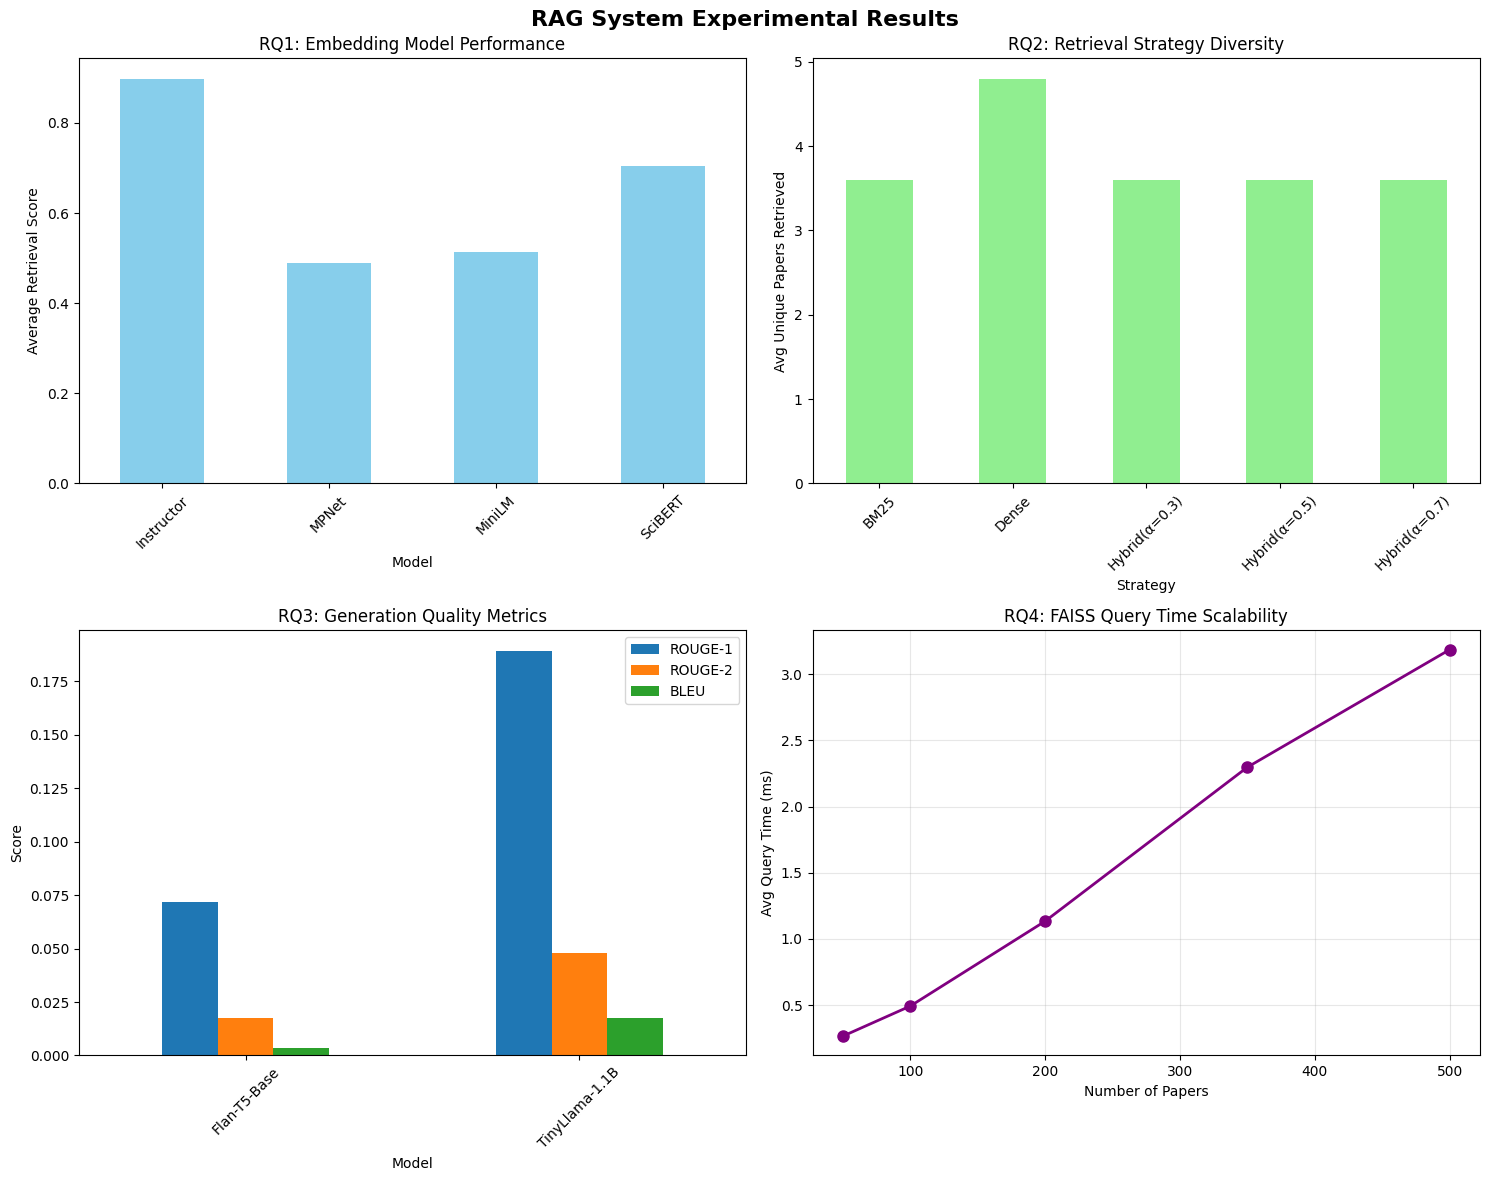


ALL EXPERIMENTS COMPLETE!

Results saved to: /content/drive/MyDrive/RAG_NLP_Project/rag_results
Files created:
- rq1_embedding_comparison.csv
- rq2_hybrid_retrieval.csv
- rq3_generation_quality.csv
- rq4_scalability.csv
- experimental_results.png


In [ ]:
# Complete RAG System - Using Pre-Generated Embeddings
import os
import numpy as np
import pandas as pd
from typing import List, Dict
from dataclasses import dataclass
import pickle
import time
import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')

base_dir = '/content/drive/MyDrive/RAG_NLP_Project'
print(f"Working directory: {base_dir}")

print("Installing required packages...")
import subprocess
subprocess.run(['pip', 'install', '-q', 'sentence-transformers', 'rank-bm25', 'faiss-cpu', 'transformers', 'torch', 'rouge-score', 'nltk', 'accelerate'], check=False)

from sentence_transformers import SentenceTransformer
from rank_bm25 import BM25Okapi
import faiss
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, AutoModelForCausalLM
import torch
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import nltk

nltk.download('punkt', quiet=True)
try:
    nltk.download('punkt_tab', quiet=True)
except:
    pass

print("All imports successful!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

device = 'cuda' if torch.cuda.is_available() else 'cpu'

@dataclass
class Chunk:
    text: str
    paper_id: str
    chunk_id: int
    paper_title: str
    authors: List[str]
    abstract: str

@dataclass
class RetrievalResult:
    chunk: Chunk
    score: float
    rank: int

print("\nLoading data from Google Drive...")
chunks_path = f"{base_dir}/document_chunks.pkl"
with open(chunks_path, 'rb') as f:
    chunk_metadata = pickle.load(f)

chunks = []
all_chunk_texts = []
for meta in chunk_metadata:
    chunk = Chunk(
        text=meta['chunk_text'],
        paper_id=meta['paper_id'],
        chunk_id=meta['chunk_id'],
        paper_title=meta['title'],
        authors=meta['authors'],
        abstract=meta['abstract']
    )
    chunks.append(chunk)
    all_chunk_texts.append(meta['chunk_text'])

unique_paper_ids = list(set([chunk.paper_id for chunk in chunks]))
num_unique_papers = len(unique_paper_ids)
print(f"Loaded {len(chunks)} chunks from {num_unique_papers} papers")

print("\nLoading pre-generated embeddings...")
embeddings_dir = f"{base_dir}/embeddings"
scibert_embeddings = np.load(f"{embeddings_dir}/scibert_embeddings.npy")
minilm_embeddings = np.load(f"{embeddings_dir}/minilm_embeddings.npy")
mpnet_embeddings = np.load(f"{embeddings_dir}/mpnet_embeddings.npy")
instructor_embeddings = np.load(f"{embeddings_dir}/instructor_embeddings.npy")

print(f"SciBERT: {scibert_embeddings.shape}")
print(f"MiniLM: {minilm_embeddings.shape}")
print(f"MPNet: {mpnet_embeddings.shape}")
print(f"Instructor: {instructor_embeddings.shape}")

class DenseRetriever:
    def __init__(self, embeddings: np.ndarray, chunks: List[Chunk]):
        self.chunks = chunks
        d = embeddings.shape[1]
        self.index = faiss.IndexFlatIP(d)
        normalized = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)
        self.index.add(normalized.astype('float32'))

    def search(self, query_embedding: np.ndarray, k: int = 5) -> List[RetrievalResult]:
        query_norm = query_embedding / np.linalg.norm(query_embedding)
        scores, indices = self.index.search(query_norm.reshape(1, -1).astype('float32'), k)
        results = []
        for rank, (idx, score) in enumerate(zip(indices[0], scores[0])):
            results.append(RetrievalResult(chunk=self.chunks[idx], score=float(score), rank=rank + 1))
        return results

class BM25Retriever:
    def __init__(self, chunks: List[Chunk]):
        self.chunks = chunks
        tokenized_corpus = [chunk.text.lower().split() for chunk in chunks]
        self.bm25 = BM25Okapi(tokenized_corpus)

    def search(self, query: str, k: int = 5) -> List[RetrievalResult]:
        tokenized_query = query.lower().split()
        scores = self.bm25.get_scores(tokenized_query)
        top_indices = np.argsort(scores)[::-1][:k]
        results = []
        for rank, idx in enumerate(top_indices):
            results.append(RetrievalResult(chunk=self.chunks[idx], score=float(scores[idx]), rank=rank + 1))
        return results

class HybridRetriever:
    def __init__(self, dense_retriever: DenseRetriever, bm25_retriever: BM25Retriever, alpha: float = 0.5):
        self.dense = dense_retriever
        self.bm25 = bm25_retriever
        self.alpha = alpha

    def search(self, query: str, query_embedding: np.ndarray, k: int = 5) -> List[RetrievalResult]:
        dense_results = self.dense.search(query_embedding, k=k*2)
        bm25_results = self.bm25.search(query, k=k*2)

        chunk_scores = {}
        for res in dense_results:
            chunk_id = (res.chunk.paper_id, res.chunk.chunk_id)
            chunk_scores[chunk_id] = {'chunk': res.chunk, 'dense': res.score, 'bm25': 0.0}

        for res in bm25_results:
            chunk_id = (res.chunk.paper_id, res.chunk.chunk_id)
            if chunk_id in chunk_scores:
                chunk_scores[chunk_id]['bm25'] = res.score
            else:
                chunk_scores[chunk_id] = {'chunk': res.chunk, 'dense': 0.0, 'bm25': res.score}

        for chunk_id in chunk_scores:
            dense_score = chunk_scores[chunk_id]['dense']
            bm25_score = chunk_scores[chunk_id]['bm25']
            chunk_scores[chunk_id]['hybrid'] = self.alpha * dense_score + (1 - self.alpha) * bm25_score

        sorted_chunks = sorted(chunk_scores.items(), key=lambda x: x[1]['hybrid'], reverse=True)
        results = []
        for rank, (chunk_id, data) in enumerate(sorted_chunks[:k]):
            results.append(RetrievalResult(chunk=data['chunk'], score=data['hybrid'], rank=rank + 1))
        return results

print("\nInitializing retrievers...")
print("Building BM25 index...")
bm25_retriever = BM25Retriever(chunks)

print("Building FAISS indexes...")
scibert_retriever = DenseRetriever(scibert_embeddings, chunks)
minilm_retriever = DenseRetriever(minilm_embeddings, chunks)
mpnet_retriever = DenseRetriever(mpnet_embeddings, chunks)
instructor_retriever = DenseRetriever(instructor_embeddings, chunks)

print("Loading embedding models for query encoding...")
scibert_model = SentenceTransformer('allenai/scibert_scivocab_uncased').to(device)
minilm_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2').to(device)
mpnet_model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2').to(device)
instructor_model = SentenceTransformer('hkunlp/instructor-base').to(device)

print("All retrievers initialized!")

class RAGGenerator:
    def __init__(self, model_name: str = "google/flan-t5-base"):
        print(f"Loading generation model: {model_name}")
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(device)
        self.model_name = model_name

    def generate(self, query: str, retrieved_chunks: List[RetrievalResult], max_length: int = 256) -> str:
        context = "\n\n".join([f"[{i+1}] {r.chunk.text[:300]}" for i, r in enumerate(retrieved_chunks[:3])])
        prompt = f"Question: {query}\n\nContext:\n{context}\n\nAnswer:"

        inputs = self.tokenizer(prompt, return_tensors="pt", max_length=512, truncation=True).to(device)

        with torch.no_grad():
            outputs = self.model.generate(
                **inputs,
                max_length=max_length,
                num_beams=4,
                early_stopping=True,
                no_repeat_ngram_size=3
            )

        answer = self.tokenizer.decode(outputs[0], skip_special_tokens=True)
        return answer

class Evaluator:
    def __init__(self):
        self.rouge_scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
        self.smoothing = SmoothingFunction()

    def evaluate_generation(self, generated: str, reference: str) -> Dict[str, float]:
        rouge_scores = self.rouge_scorer.score(reference, generated)

        gen_tokens = generated.lower().split()
        ref_tokens = reference.lower().split()
        bleu = sentence_bleu([ref_tokens], gen_tokens, smoothing_function=self.smoothing.method1)

        return {
            'rouge1': rouge_scores['rouge1'].fmeasure,
            'rouge2': rouge_scores['rouge2'].fmeasure,
            'rougeL': rouge_scores['rougeL'].fmeasure,
            'bleu': bleu
        }

print("\nInitializing generation models...")
flan_t5_generator = RAGGenerator("google/flan-t5-base")

print("Loading TinyLlama...")
tinyllama_tokenizer = AutoTokenizer.from_pretrained("TinyLlama/TinyLlama-1.1B-Chat-v1.0")
tinyllama_model = AutoModelForCausalLM.from_pretrained("TinyLlama/TinyLlama-1.1B-Chat-v1.0", torch_dtype=torch.float16).to(device)

evaluator = Evaluator()

test_queries = [
    "What are attention mechanisms in transformer models?",
    "How do large language models process natural language?",
    "What is retrieval augmented generation?",
    "Explain the benefits of pre-training in NLP",
    "How does BERT differ from GPT models?"
]

print("\n" + "="*80)
print("STARTING EXPERIMENTS")
print("="*80)

print("\n--- RQ1: Embedding Model Comparison ---")
embedding_models = {
    'SciBERT': (scibert_retriever, scibert_model),
    'MiniLM': (minilm_retriever, minilm_model),
    'MPNet': (mpnet_retriever, mpnet_model),
    'Instructor': (instructor_retriever, instructor_model)
}

rq1_results = []
for model_name, (retriever, encoder) in embedding_models.items():
    print(f"\nEvaluating {model_name}...")
    for query in test_queries:
        query_embedding = encoder.encode(query, convert_to_tensor=True).cpu().numpy()
        results = retriever.search(query_embedding, k=5)

        avg_score = np.mean([r.score for r in results])
        unique_papers = len(set([r.chunk.paper_id for r in results]))

        rq1_results.append({
            'Model': model_name,
            'Query': query[:50],
            'Avg_Score': avg_score,
            'Unique_Papers': unique_papers
        })

df_rq1 = pd.DataFrame(rq1_results)
print("\nRQ1 Results Summary:")
print(df_rq1.groupby('Model')[['Avg_Score', 'Unique_Papers']].mean())

print("\n--- RQ2: Hybrid Retrieval Optimization ---")
alphas = [0.0, 0.3, 0.5, 0.7, 1.0]
rq2_results = []

for alpha in alphas:
    strategy_name = f"Dense" if alpha == 1.0 else f"BM25" if alpha == 0.0 else f"Hybrid(α={alpha})"
    hybrid_retriever = HybridRetriever(scibert_retriever, bm25_retriever, alpha=alpha)

    for query in test_queries:
        query_embedding = scibert_model.encode(query, convert_to_tensor=True).cpu().numpy()
        results = hybrid_retriever.search(query, query_embedding, k=5)

        avg_score = np.mean([r.score for r in results])
        unique_papers = len(set([r.chunk.paper_id for r in results]))

        rq2_results.append({
            'Alpha': alpha,
            'Strategy': strategy_name,
            'Query': query[:50],
            'Avg_Score': avg_score,
            'Unique_Papers': unique_papers
        })

df_rq2 = pd.DataFrame(rq2_results)
print("\nRQ2 Results Summary:")
print(df_rq2.groupby('Strategy')[['Avg_Score', 'Unique_Papers']].mean())

print("\n--- RQ3: Generation Quality Comparison ---")
optimal_hybrid = HybridRetriever(scibert_retriever, bm25_retriever, alpha=0.5)
rq3_results = []

reference_answers = [
    "Attention mechanisms allow models to focus on relevant parts of the input sequence by computing weighted representations.",
    "Large language models use transformer architectures to process text through layers of attention and feed-forward networks.",
    "Retrieval augmented generation combines information retrieval with language generation to produce factually grounded responses.",
    "Pre-training helps models learn general language representations that transfer to downstream tasks.",
    "BERT uses bidirectional encoding while GPT uses unidirectional autoregressive generation."
]

for query, reference in zip(test_queries, reference_answers):
    print(f"\nProcessing: {query[:50]}...")
    query_embedding = scibert_model.encode(query, convert_to_tensor=True).cpu().numpy()
    retrieved = optimal_hybrid.search(query, query_embedding, k=5)

    flan_answer = flan_t5_generator.generate(query, retrieved, max_length=128)

    context = "\n".join([r.chunk.text[:200] for r in retrieved[:3]])
    tinyllama_prompt = f"<|system|>You are a helpful AI assistant.</s>\n<|user|>\nQuestion: {query}\n\nContext: {context}\n\nProvide a concise answer.</s>\n<|assistant|>"
    tinyllama_inputs = tinyllama_tokenizer(tinyllama_prompt, return_tensors="pt", max_length=512, truncation=True).to(device)

    with torch.no_grad():
        tinyllama_outputs = tinyllama_model.generate(**tinyllama_inputs, max_new_tokens=128, temperature=0.7, do_sample=True)
    tinyllama_answer = tinyllama_tokenizer.decode(tinyllama_outputs[0], skip_special_tokens=True)
    tinyllama_answer = tinyllama_answer.split("<|assistant|>")[-1].strip()[:500]

    flan_metrics = evaluator.evaluate_generation(flan_answer, reference)
    tinyllama_metrics = evaluator.evaluate_generation(tinyllama_answer, reference)

    rq3_results.append({
        'Model': 'Flan-T5-Base',
        'Query': query[:50],
        'ROUGE-1': flan_metrics['rouge1'],
        'ROUGE-2': flan_metrics['rouge2'],
        'BLEU': flan_metrics['bleu'],
        'Answer_Length': len(flan_answer.split())
    })

    rq3_results.append({
        'Model': 'TinyLlama-1.1B',
        'Query': query[:50],
        'ROUGE-1': tinyllama_metrics['rouge1'],
        'ROUGE-2': tinyllama_metrics['rouge2'],
        'BLEU': tinyllama_metrics['bleu'],
        'Answer_Length': len(tinyllama_answer.split())
    })

df_rq3 = pd.DataFrame(rq3_results)
print("\nRQ3 Results Summary:")
print(df_rq3.groupby('Model')[['ROUGE-1', 'ROUGE-2', 'BLEU', 'Answer_Length']].mean())

print("\n--- RQ4: FAISS Scalability Test ---")
avg_chunks_per_paper = len(chunks) / num_unique_papers
dataset_sizes = [50, 100, 200, 350, 500]
rq4_results = []

for size in dataset_sizes:
    print(f"\nTesting with {size} papers...")
    num_chunks_for_size = int(avg_chunks_per_paper * size)
    subset_chunks = chunks[:num_chunks_for_size]
    subset_embeddings = scibert_embeddings[:num_chunks_for_size]

    start_time = time.time()
    test_retriever = DenseRetriever(subset_embeddings, subset_chunks)
    index_time = (time.time() - start_time) * 1000

    query_times = []
    for query in test_queries:
        query_embedding = scibert_model.encode(query, convert_to_tensor=True).cpu().numpy()
        start = time.time()
        test_retriever.search(query_embedding, k=5)
        query_times.append((time.time() - start) * 1000)

    rq4_results.append({
        'Num_Papers': size,
        'Num_Chunks': len(subset_chunks),
        'Indexing_Time_ms': index_time,
        'Avg_Query_Time_ms': np.mean(query_times),
        'Max_Query_Time_ms': np.max(query_times)
    })

df_rq4 = pd.DataFrame(rq4_results)
print("\nRQ4 Results Summary:")
print(df_rq4)

results_dir = f"{base_dir}/rag_results"
os.makedirs(results_dir, exist_ok=True)

df_rq1.to_csv(f"{results_dir}/rq1_embedding_comparison.csv", index=False)
df_rq2.to_csv(f"{results_dir}/rq2_hybrid_retrieval.csv", index=False)
df_rq3.to_csv(f"{results_dir}/rq3_generation_quality.csv", index=False)
df_rq4.to_csv(f"{results_dir}/rq4_scalability.csv", index=False)

print(f"\nAll results saved to: {results_dir}")

try:
    import matplotlib.pyplot as plt

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('RAG System Experimental Results', fontsize=16, fontweight='bold')

    ax1 = axes[0, 0]
    df_rq1.groupby('Model')['Avg_Score'].mean().plot(kind='bar', ax=ax1, color='skyblue')
    ax1.set_title('RQ1: Embedding Model Performance')
    ax1.set_ylabel('Average Retrieval Score')
    ax1.set_xlabel('Model')
    ax1.tick_params(axis='x', rotation=45)

    ax2 = axes[0, 1]
    df_rq2.groupby('Strategy')['Unique_Papers'].mean().plot(kind='bar', ax=ax2, color='lightgreen')
    ax2.set_title('RQ2: Retrieval Strategy Diversity')
    ax2.set_ylabel('Avg Unique Papers Retrieved')
    ax2.set_xlabel('Strategy')
    ax2.tick_params(axis='x', rotation=45)

    ax3 = axes[1, 0]
    df_rq3.groupby('Model')[['ROUGE-1', 'ROUGE-2', 'BLEU']].mean().plot(kind='bar', ax=ax3)
    ax3.set_title('RQ3: Generation Quality Metrics')
    ax3.set_ylabel('Score')
    ax3.set_xlabel('Model')
    ax3.legend(loc='best')
    ax3.tick_params(axis='x', rotation=45)

    ax4 = axes[1, 1]
    ax4.plot(df_rq4['Num_Papers'], df_rq4['Avg_Query_Time_ms'], marker='o', linewidth=2, markersize=8, color='purple')
    ax4.set_title('RQ4: FAISS Query Time Scalability')
    ax4.set_xlabel('Number of Papers')
    ax4.set_ylabel('Avg Query Time (ms)')
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f"{results_dir}/experimental_results.png", dpi=300, bbox_inches='tight')
    print(f"Visualization saved to: {results_dir}/experimental_results.png")
    plt.show()

except Exception as e:
    print(f"Could not create visualization: {str(e)}")

print("\n" + "="*80)
print("ALL EXPERIMENTS COMPLETE!")
print("="*80)
print(f"\nResults saved to: {results_dir}")
print("Files created:")
print("- rq1_embedding_comparison.csv")
print("- rq2_hybrid_retrieval.csv")
print("- rq3_generation_quality.csv")
print("- rq4_scalability.csv")
print("- experimental_results.png")

In [ ]:
# Advanced Visualizations for Presentation
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib.patches import Rectangle
import warnings
warnings.filterwarnings('ignore')

# Set style for better looking plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Load the results from previous experiment
results_dir = f"{base_dir}/rag_results"

df_rq1 = pd.read_csv(f"{results_dir}/rq1_embedding_comparison.csv")
df_rq2 = pd.read_csv(f"{results_dir}/rq2_hybrid_retrieval.csv")
df_rq3 = pd.read_csv(f"{results_dir}/rq3_generation_quality.csv")
df_rq4 = pd.read_csv(f"{results_dir}/rq4_scalability.csv")

print("Creating advanced visualizations for presentation...")

# Create output directory for visualizations
viz_dir = f"{base_dir}/visualizations"
os.makedirs(viz_dir, exist_ok=True)

# 1. HEATMAP: Embedding Model Performance Across Queries
print("\n1. Creating embedding performance heatmap...")
fig, ax = plt.subplots(figsize=(12, 8))

pivot_rq1 = df_rq1.pivot_table(values='Avg_Score', index='Query', columns='Model')
sns.heatmap(pivot_rq1, annot=True, fmt='.3f', cmap='YlOrRd', cbar_kws={'label': 'Retrieval Score'}, ax=ax)
ax.set_title('RQ1: Embedding Model Performance Heatmap\nRetrieval Scores Across Different Queries', fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Embedding Model', fontsize=12, fontweight='bold')
ax.set_ylabel('Query', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(f"{viz_dir}/heatmap_embedding_performance.png", dpi=300, bbox_inches='tight')
print(f"Saved: heatmap_embedding_performance.png")
plt.close()

# 2. GENERATION QUALITY COMPARISON: Side-by-Side Metrics
print("\n2. Creating generation quality comparison...")
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

metrics = ['ROUGE-1', 'ROUGE-2', 'BLEU']
colors = ['#3498db', '#e74c3c']

for idx, metric in enumerate(metrics):
    ax = axes[idx]
    model_scores = df_rq3.groupby('Model')[metric].mean()

    bars = ax.bar(model_scores.index, model_scores.values, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)

    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}',
                ha='center', va='bottom', fontweight='bold', fontsize=11)

    ax.set_title(f'{metric}', fontsize=13, fontweight='bold')
    ax.set_ylabel('Score', fontsize=11, fontweight='bold')
    ax.set_ylim(0, max(model_scores.values) * 1.2)
    ax.tick_params(axis='x', rotation=45)
    ax.grid(axis='y', alpha=0.3)

fig.suptitle('RQ3: Generation Quality Comparison\nFlan-T5-Base vs TinyLlama-1.1B', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(f"{viz_dir}/generation_quality_comparison.png", dpi=300, bbox_inches='tight')
print(f"Saved: generation_quality_comparison.png")
plt.close()

# 3. GENERATION QUALITY HEATMAP: Query vs Model
print("\n3. Creating generation quality heatmap...")
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for idx, metric in enumerate(metrics):
    ax = axes[idx]
    pivot_rq3 = df_rq3.pivot_table(values=metric, index='Query', columns='Model')
    sns.heatmap(pivot_rq3, annot=True, fmt='.3f', cmap='RdYlGn', ax=ax, cbar_kws={'label': 'Score'})
    ax.set_title(f'{metric}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Model', fontsize=10, fontweight='bold')
    ax.set_ylabel('Query', fontsize=10, fontweight='bold')
    ax.tick_params(axis='x', rotation=45)
    ax.tick_params(axis='y', rotation=0)

fig.suptitle('RQ3: Generation Quality Heatmap\nDetailed Performance Across Queries', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(f"{viz_dir}/generation_quality_heatmap.png", dpi=300, bbox_inches='tight')
print(f"Saved: generation_quality_heatmap.png")
plt.close()

# 4. ANSWER LENGTH COMPARISON
print("\n4. Creating answer length comparison...")
fig, ax = plt.subplots(figsize=(10, 6))

answer_lengths = df_rq3.groupby('Model')['Answer_Length'].mean()
bars = ax.bar(answer_lengths.index, answer_lengths.values, color=['#3498db', '#e74c3c'], alpha=0.8, edgecolor='black', linewidth=2)

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f} words',
            ha='center', va='bottom', fontweight='bold', fontsize=12)

ax.set_title('RQ3: Average Answer Length Comparison', fontsize=14, fontweight='bold', pad=20)
ax.set_ylabel('Average Words per Answer', fontsize=12, fontweight='bold')
ax.set_ylim(0, max(answer_lengths.values) * 1.2)
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig(f"{viz_dir}/answer_length_comparison.png", dpi=300, bbox_inches='tight')
print(f"Saved: answer_length_comparison.png")
plt.close()

# 5. HYBRID RETRIEVAL PERFORMANCE
print("\n5. Creating hybrid retrieval performance visualization...")
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Avg Score by Strategy
ax1 = axes[0]
strategy_scores = df_rq2.groupby('Strategy')['Avg_Score'].mean().sort_values()
colors_gradient = plt.cm.viridis(np.linspace(0, 1, len(strategy_scores)))
bars1 = ax1.barh(strategy_scores.index, strategy_scores.values, color=colors_gradient, edgecolor='black', linewidth=1.5)

for bar in bars1:
    width = bar.get_width()
    ax1.text(width, bar.get_y() + bar.get_height()/2.,
            f'{width:.2f}',
            ha='left', va='center', fontweight='bold', fontsize=10, color='black')

ax1.set_xlabel('Average Score', fontsize=11, fontweight='bold')
ax1.set_title('Average Retrieval Score by Strategy', fontsize=12, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

# Plot 2: Unique Papers Retrieved
ax2 = axes[1]
unique_papers = df_rq2.groupby('Strategy')['Unique_Papers'].mean().sort_values()
bars2 = ax2.barh(unique_papers.index, unique_papers.values, color=colors_gradient, edgecolor='black', linewidth=1.5)

for bar in bars2:
    width = bar.get_width()
    ax2.text(width, bar.get_y() + bar.get_height()/2.,
            f'{width:.1f}',
            ha='left', va='center', fontweight='bold', fontsize=10, color='black')

ax2.set_xlabel('Unique Papers Retrieved', fontsize=11, fontweight='bold')
ax2.set_title('Diversity: Unique Papers by Strategy', fontsize=12, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

fig.suptitle('RQ2: Hybrid Retrieval Optimization Results', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(f"{viz_dir}/hybrid_retrieval_performance.png", dpi=300, bbox_inches='tight')
print(f"Saved: hybrid_retrieval_performance.png")
plt.close()

# 6. SCALABILITY VISUALIZATION
print("\n6. Creating scalability visualization...")
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Query Time vs Dataset Size
ax1 = axes[0]
ax1.plot(df_rq4['Num_Papers'], df_rq4['Avg_Query_Time_ms'],
         marker='o', linewidth=3, markersize=10, color='#2ecc71', label='Average Query Time')
ax1.fill_between(df_rq4['Num_Papers'],
                 df_rq4['Avg_Query_Time_ms'],
                 alpha=0.3, color='#2ecc71')

for i, row in df_rq4.iterrows():
    ax1.annotate(f"{row['Avg_Query_Time_ms']:.2f}ms",
                xy=(row['Num_Papers'], row['Avg_Query_Time_ms']),
                xytext=(0, 10), textcoords='offset points',
                ha='center', fontweight='bold', fontsize=9)

ax1.set_xlabel('Number of Papers', fontsize=11, fontweight='bold')
ax1.set_ylabel('Average Query Time (ms)', fontsize=11, fontweight='bold')
ax1.set_title('FAISS Query Time Scalability', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Plot 2: Indexing Time vs Dataset Size
ax2 = axes[1]
ax2.bar(df_rq4['Num_Papers'], df_rq4['Indexing_Time_ms'],
        color='#e74c3c', alpha=0.7, edgecolor='black', linewidth=1.5)

for i, row in df_rq4.iterrows():
    ax2.text(row['Num_Papers'], row['Indexing_Time_ms'],
            f"{row['Indexing_Time_ms']:.2f}ms",
            ha='center', va='bottom', fontweight='bold', fontsize=9)

ax2.set_xlabel('Number of Papers', fontsize=11, fontweight='bold')
ax2.set_ylabel('Indexing Time (ms)', fontsize=11, fontweight='bold')
ax2.set_title('FAISS Indexing Time', fontsize=12, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

fig.suptitle('RQ4: FAISS Performance and Scalability', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(f"{viz_dir}/scalability_analysis.png", dpi=300, bbox_inches='tight')
print(f"Saved: scalability_analysis.png")
plt.close()

# 7. RADAR CHART: Overall Model Comparison
print("\n7. Creating radar chart for overall comparison...")
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

categories = ['ROUGE-1', 'ROUGE-2', 'BLEU', 'Coherence\n(Length/10)']
num_vars = len(categories)

angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

flan_values = [
    df_rq3[df_rq3['Model'] == 'Flan-T5-Base']['ROUGE-1'].mean(),
    df_rq3[df_rq3['Model'] == 'Flan-T5-Base']['ROUGE-2'].mean(),
    df_rq3[df_rq3['Model'] == 'Flan-T5-Base']['BLEU'].mean(),
    df_rq3[df_rq3['Model'] == 'Flan-T5-Base']['Answer_Length'].mean() / 10
]
flan_values += flan_values[:1]

tinyllama_values = [
    df_rq3[df_rq3['Model'] == 'TinyLlama-1.1B']['ROUGE-1'].mean(),
    df_rq3[df_rq3['Model'] == 'TinyLlama-1.1B']['ROUGE-2'].mean(),
    df_rq3[df_rq3['Model'] == 'TinyLlama-1.1B']['BLEU'].mean(),
    df_rq3[df_rq3['Model'] == 'TinyLlama-1.1B']['Answer_Length'].mean() / 10
]
tinyllama_values += tinyllama_values[:1]

ax.plot(angles, flan_values, 'o-', linewidth=3, label='Flan-T5-Base', color='#3498db')
ax.fill(angles, flan_values, alpha=0.25, color='#3498db')

ax.plot(angles, tinyllama_values, 'o-', linewidth=3, label='TinyLlama-1.1B', color='#e74c3c')
ax.fill(angles, tinyllama_values, alpha=0.25, color='#e74c3c')

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=11, fontweight='bold')
ax.set_ylim(0, 0.2)
ax.set_title('Generation Model Performance Comparison\n(Radar Chart)', fontsize=14, fontweight='bold', pad=30)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=11)
ax.grid(True)

plt.tight_layout()
plt.savefig(f"{viz_dir}/radar_chart_comparison.png", dpi=300, bbox_inches='tight')
print(f"Saved: radar_chart_comparison.png")
plt.close()

# 8. COMPREHENSIVE EMBEDDING COMPARISON
print("\n8. Creating comprehensive embedding comparison...")
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Average Scores
ax1 = axes[0, 0]
model_scores = df_rq1.groupby('Model')['Avg_Score'].mean().sort_values(ascending=False)
colors = ['#2ecc71', '#3498db', '#e74c3c', '#f39c12']
bars = ax1.bar(model_scores.index, model_scores.values, color=colors, edgecolor='black', linewidth=2)
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}',
            ha='center', va='bottom', fontweight='bold', fontsize=10)
ax1.set_title('Average Retrieval Scores', fontsize=12, fontweight='bold')
ax1.set_ylabel('Score', fontsize=10, fontweight='bold')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(axis='y', alpha=0.3)

# Plot 2: Unique Papers Retrieved
ax2 = axes[0, 1]
unique_papers = df_rq1.groupby('Model')['Unique_Papers'].mean().sort_values(ascending=False)
bars = ax2.bar(unique_papers.index, unique_papers.values, color=colors, edgecolor='black', linewidth=2)
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}',
            ha='center', va='bottom', fontweight='bold', fontsize=10)
ax2.set_title('Average Unique Papers Retrieved', fontsize=12, fontweight='bold')
ax2.set_ylabel('Count', fontsize=10, fontweight='bold')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(axis='y', alpha=0.3)

# Plot 3: Score Distribution
ax3 = axes[1, 0]
for model in df_rq1['Model'].unique():
    model_data = df_rq1[df_rq1['Model'] == model]['Avg_Score']
    ax3.hist(model_data, alpha=0.6, label=model, bins=10, edgecolor='black')
ax3.set_title('Score Distribution Across Queries', fontsize=12, fontweight='bold')
ax3.set_xlabel('Retrieval Score', fontsize=10, fontweight='bold')
ax3.set_ylabel('Frequency', fontsize=10, fontweight='bold')
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

# Plot 4: Model Ranking
ax4 = axes[1, 1]
models = model_scores.index
ranks = range(1, len(models) + 1)
ax4.barh(models, ranks, color=colors, edgecolor='black', linewidth=2)
for i, (model, rank) in enumerate(zip(models, ranks)):
    ax4.text(rank, i, f'  Rank {rank}', va='center', fontweight='bold', fontsize=10)
ax4.set_xlabel('Ranking (Lower is Better)', fontsize=10, fontweight='bold')
ax4.set_title('Model Performance Ranking', fontsize=12, fontweight='bold')
ax4.invert_xaxis()
ax4.grid(axis='x', alpha=0.3)

fig.suptitle('RQ1: Comprehensive Embedding Model Analysis', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig(f"{viz_dir}/comprehensive_embedding_analysis.png", dpi=300, bbox_inches='tight')
print(f"Saved: comprehensive_embedding_analysis.png")
plt.close()

# 9. GENERATE EXAMPLE OUTPUTS TABLE
print("\n9. Generating example outputs for presentation...")

# Re-run generation for sample queries to get actual outputs
sample_queries = test_queries[:3]
example_outputs = []

optimal_hybrid = HybridRetriever(scibert_retriever, bm25_retriever, alpha=0.5)

for query in sample_queries:
    print(f"Generating examples for: {query[:50]}...")
    query_embedding = scibert_model.encode(query, convert_to_tensor=True).cpu().numpy()
    retrieved = optimal_hybrid.search(query, query_embedding, k=5)

    # Flan-T5 generation
    flan_answer = flan_t5_generator.generate(query, retrieved, max_length=128)

    # TinyLlama generation
    context = "\n".join([r.chunk.text[:200] for r in retrieved[:3]])
    tinyllama_prompt = f"<|system|>You are a helpful AI assistant.</s>\n<|user|>\nQuestion: {query}\n\nContext: {context}\n\nProvide a concise answer.</s>\n<|assistant|>"
    tinyllama_inputs = tinyllama_tokenizer(tinyllama_prompt, return_tensors="pt", max_length=512, truncation=True).to(device)

    with torch.no_grad():
        tinyllama_outputs = tinyllama_model.generate(**tinyllama_inputs, max_new_tokens=128, temperature=0.7, do_sample=True)
    tinyllama_answer = tinyllama_tokenizer.decode(tinyllama_outputs[0], skip_special_tokens=True)
    tinyllama_answer = tinyllama_answer.split("<|assistant|>")[-1].strip()[:300]

    example_outputs.append({
        'Query': query,
        'Flan-T5-Base': flan_answer,
        'TinyLlama-1.1B': tinyllama_answer
    })

# Save examples to CSV
examples_df = pd.DataFrame(example_outputs)
examples_df.to_csv(f"{viz_dir}/generation_examples.csv", index=False)
print(f"Saved: generation_examples.csv")

# Create visual table of examples
fig, ax = plt.subplots(figsize=(18, 10))
ax.axis('tight')
ax.axis('off')

# Prepare table data
table_data = []
for idx, row in examples_df.iterrows():
    table_data.append([
        f"Q{idx+1}:\n{row['Query'][:50]}...",
        row['Flan-T5-Base'][:150] + "..." if len(row['Flan-T5-Base']) > 150 else row['Flan-T5-Base'],
        row['TinyLlama-1.1B'][:150] + "..." if len(row['TinyLlama-1.1B']) > 150 else row['TinyLlama-1.1B']
    ])

table = ax.table(cellText=table_data,
                colLabels=['Query', 'Flan-T5-Base', 'TinyLlama-1.1B'],
                cellLoc='left',
                loc='center',
                colWidths=[0.2, 0.4, 0.4])

table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 3)

for i in range(len(table_data) + 1):
    for j in range(3):
        cell = table[(i, j)]
        if i == 0:
            cell.set_facecolor('#3498db')
            cell.set_text_props(weight='bold', color='white')
        else:
            if j == 0:
                cell.set_facecolor('#ecf0f1')
            elif j == 1:
                cell.set_facecolor('#d5e8f7')
            else:
                cell.set_facecolor('#f5d5d5')

plt.title('Generation Examples: Flan-T5-Base vs TinyLlama-1.1B', fontsize=16, fontweight='bold', pad=20)
plt.savefig(f"{viz_dir}/generation_examples_table.png", dpi=300, bbox_inches='tight')
print(f"Saved: generation_examples_table.png")
plt.close()

# 10. CREATE SUMMARY STATISTICS TABLE
print("\n10. Creating summary statistics table...")
fig, ax = plt.subplots(figsize=(14, 8))
ax.axis('tight')
ax.axis('off')

summary_data = []

# RQ1 Summary
rq1_summary = df_rq1.groupby('Model')[['Avg_Score', 'Unique_Papers']].mean()
summary_data.append(['RQ1: Embedding Models', '', '', ''])
for model in rq1_summary.index:
    summary_data.append([
        f"  {model}",
        f"{rq1_summary.loc[model, 'Avg_Score']:.4f}",
        f"{rq1_summary.loc[model, 'Unique_Papers']:.2f}",
        ''
    ])

summary_data.append(['', '', '', ''])

# RQ2 Summary
rq2_summary = df_rq2.groupby('Strategy')[['Avg_Score', 'Unique_Papers']].mean()
summary_data.append(['RQ2: Retrieval Strategies', '', '', ''])
for strategy in rq2_summary.index:
    summary_data.append([
        f"  {strategy}",
        f"{rq2_summary.loc[strategy, 'Avg_Score']:.4f}",
        f"{rq2_summary.loc[strategy, 'Unique_Papers']:.2f}",
        ''
    ])

summary_data.append(['', '', '', ''])

# RQ3 Summary
rq3_summary = df_rq3.groupby('Model')[['ROUGE-1', 'ROUGE-2', 'BLEU']].mean()
summary_data.append(['RQ3: Generation Quality', '', '', ''])
for model in rq3_summary.index:
    summary_data.append([
        f"  {model}",
        f"R1: {rq3_summary.loc[model, 'ROUGE-1']:.4f}",
        f"R2: {rq3_summary.loc[model, 'ROUGE-2']:.4f}",
        f"BLEU: {rq3_summary.loc[model, 'BLEU']:.4f}"
    ])

table = ax.table(cellText=summary_data,
                colLabels=['Category', 'Metric 1', 'Metric 2', 'Metric 3'],
                cellLoc='left',
                loc='center',
                colWidths=[0.3, 0.25, 0.25, 0.2])

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2.5)

for i in range(len(summary_data) + 1):
    for j in range(4):
        cell = table[(i, j)]
        if i == 0:
            cell.set_facecolor('#2c3e50')
            cell.set_text_props(weight='bold', color='white')
        elif 'RQ' in str(summary_data[i-1][0]):
            cell.set_facecolor('#3498db')
            cell.set_text_props(weight='bold', color='white')
        elif summary_data[i-1][0] == '':
            cell.set_facecolor('#ffffff')
        else:
            cell.set_facecolor('#ecf0f1')

plt.title('Experimental Results Summary', fontsize=16, fontweight='bold', pad=20)
plt.savefig(f"{viz_dir}/summary_statistics_table.png", dpi=300, bbox_inches='tight')
print(f"Saved: summary_statistics_table.png")
plt.close()

print("\n" + "="*80)
print("ALL VISUALIZATIONS COMPLETE!")
print("="*80)
print(f"\nVisualization files saved to: {viz_dir}")
print("\nGenerated files:")
print("1. heatmap_embedding_performance.png")
print("2. generation_quality_comparison.png")
print("3. generation_quality_heatmap.png")
print("4. answer_length_comparison.png")
print("5. hybrid_retrieval_performance.png")
print("6. scalability_analysis.png")
print("7. radar_chart_comparison.png")
print("8. comprehensive_embedding_analysis.png")
print("9. generation_examples_table.png")
print("10. generation_examples.csv")
print("11. summary_statistics_table.png")
print("\nAll visualizations are ready for your presentation!")

Creating advanced visualizations for presentation...

1. Creating embedding performance heatmap...
Saved: heatmap_embedding_performance.png

2. Creating generation quality comparison...
Saved: generation_quality_comparison.png

3. Creating generation quality heatmap...
Saved: generation_quality_heatmap.png

4. Creating answer length comparison...
Saved: answer_length_comparison.png

5. Creating hybrid retrieval performance visualization...
Saved: hybrid_retrieval_performance.png

6. Creating scalability visualization...
Saved: scalability_analysis.png

7. Creating radar chart for overall comparison...
Saved: radar_chart_comparison.png

8. Creating comprehensive embedding comparison...
Saved: comprehensive_embedding_analysis.png

9. Generating example outputs for presentation...
Generating examples for: What are attention mechanisms in transformer model...
Generating examples for: How do large language models process natural langu...
Generating examples for: What is retrieval augmented 

In [ ]:
# Citation-Enhanced RAG System with CSV Output - FIXED
import pandas as pd
import re
from typing import List, Dict

class CitationRAG:
    def __init__(self, retriever, encoder, generator, model_name):
        self.retriever = retriever
        self.encoder = encoder
        self.generator = generator
        self.model_name = model_name

    def query_with_citations(self, query: str, k: int = 5) -> Dict:
        """Generate answer with proper citations"""

        # Encode query
        query_embedding = self.encoder.encode(query, convert_to_tensor=True).cpu().numpy()

        # Retrieve relevant chunks - FIXED: pass both query and query_embedding
        if hasattr(self.retriever, 'search') and 'query' in self.retriever.search.__code__.co_varnames:
            # For HybridRetriever (needs both query string and embedding)
            retrieved = self.retriever.search(query, query_embedding, k=k)
        else:
            # For DenseRetriever (only needs embedding)
            retrieved = self.retriever.search(query_embedding, k=k)

        # Extract unique papers
        papers_used = {}
        for idx, result in enumerate(retrieved, 1):
            paper_id = result.chunk.paper_id
            if paper_id not in papers_used:
                papers_used[paper_id] = {
                    'citation_number': len(papers_used) + 1,
                    'title': result.chunk.paper_title,
                    'authors': result.chunk.authors[:3],
                    'paper_id': paper_id,
                    'score': result.score
                }

        # Generate answer
        if self.model_name == "Flan-T5-Base":
            answer = self.generator.generate(query, retrieved, max_length=256)
        else:  # TinyLlama
            context = "\n".join([f"[{papers_used[r.chunk.paper_id]['citation_number']}] {r.chunk.text[:200]}"
                                for r in retrieved[:3]])
            prompt = f"""<|system|>You are a helpful research assistant. Cite sources using [number] format.</s>
<|user|>
Question: {query}

Context from papers:
{context}

Provide a detailed answer with citations [1], [2], etc.</s>
<|assistant|>"""

            inputs = tinyllama_tokenizer(prompt, return_tensors="pt", max_length=512, truncation=True).to(device)
            with torch.no_grad():
                outputs = tinyllama_model.generate(**inputs, max_new_tokens=256, temperature=0.7, do_sample=True)
            answer = tinyllama_tokenizer.decode(outputs[0], skip_special_tokens=True)
            answer = answer.split("<|assistant|>")[-1].strip()

        # Format citations
        citations = []
        for paper_id, info in papers_used.items():
            authors_str = ", ".join(info['authors'][:2]) if len(info['authors']) >= 2 else info['authors'][0] if info['authors'] else "Unknown"
            if len(info['authors']) > 2:
                authors_str += " et al."
            citation = f"[{info['citation_number']}] {authors_str} - \"{info['title'][:80]}...\""
            citations.append(citation)

        return {
            'query': query,
            'answer': answer,
            'citations': citations,
            'num_papers_cited': len(papers_used),
            'papers_used': list(papers_used.values())
        }

# Initialize citation-enhanced systems
print("Initializing Citation-Enhanced RAG Systems...")

hybrid_retriever = HybridRetriever(scibert_retriever, bm25_retriever, alpha=0.5)

citation_flan = CitationRAG(
    retriever=hybrid_retriever,
    encoder=scibert_model,
    generator=flan_t5_generator,
    model_name="Flan-T5-Base"
)

citation_tinyllama = CitationRAG(
    retriever=hybrid_retriever,
    encoder=scibert_model,
    generator=None,
    model_name="TinyLlama-1.1B"
)

# Test queries
test_queries = [
    "What are attention mechanisms in transformer models?",
    "How do large language models process natural language?",
    "What is retrieval augmented generation?",
    "Explain the benefits of pre-training in NLP",
    "How does BERT differ from GPT models?",
    "What are the main challenges in neural machine translation?",
    "How do embeddings capture semantic meaning?",
    "What is the role of positional encoding in transformers?"
]

print("\nGenerating answers with citations...")
results = []

for query in test_queries:
    print(f"\nProcessing: {query[:60]}...")

    # Flan-T5 with citations
    flan_result = citation_flan.query_with_citations(query, k=5)

    # TinyLlama with citations
    tinyllama_result = citation_tinyllama.query_with_citations(query, k=5)

    # Format for CSV
    results.append({
        'Query': query,
        'Model': 'Flan-T5-Base',
        'Answer': flan_result['answer'],
        'Citations': '\n'.join(flan_result['citations']),
        'Num_Papers_Cited': flan_result['num_papers_cited'],
        'Citation_List': '; '.join(flan_result['citations'])
    })

    results.append({
        'Query': query,
        'Model': 'TinyLlama-1.1B',
        'Answer': tinyllama_result['answer'],
        'Citations': '\n'.join(tinyllama_result['citations']),
        'Num_Papers_Cited': tinyllama_result['num_papers_cited'],
        'Citation_List': '; '.join(tinyllama_result['citations'])
    })

# Create DataFrame
df_citations = pd.DataFrame(results)

# Save to CSV
output_path = f"{base_dir}/rag_results/generation_with_citations.csv"
df_citations.to_csv(output_path, index=False)
print(f"\n✓ Results saved to: {output_path}")

# Create summary table for PPT
summary_data = []
for query in test_queries:
    query_results = df_citations[df_citations['Query'] == query]

    flan_row = query_results[query_results['Model'] == 'Flan-T5-Base'].iloc[0]
    tiny_row = query_results[query_results['Model'] == 'TinyLlama-1.1B'].iloc[0]

    summary_data.append({
        'Query': query[:50] + "...",
        'Flan_T5_Answer': flan_row['Answer'][:100] + "...",
        'Flan_T5_Citations': flan_row['Num_Papers_Cited'],
        'TinyLlama_Answer': tiny_row['Answer'][:100] + "...",
        'TinyLlama_Citations': tiny_row['Num_Papers_Cited']
    })

df_summary = pd.DataFrame(summary_data)
summary_path = f"{base_dir}/rag_results/citation_summary_for_ppt.csv"
df_summary.to_csv(summary_path, index=False)
print(f"✓ Summary table saved to: {summary_path}")

# Display sample results
print("\n" + "="*80)
print("SAMPLE OUTPUT WITH CITATIONS")
print("="*80)

sample_query = test_queries[0]
sample_results = df_citations[df_citations['Query'] == sample_query]

for _, row in sample_results.iterrows():
    print(f"\nModel: {row['Model']}")
    print(f"Query: {row['Query']}")
    print(f"\nAnswer:\n{row['Answer'][:300]}...")
    print(f"\nCitations ({row['Num_Papers_Cited']} papers):")
    print(row['Citations'])
    print("-"*80)

# Create detailed citation table
print("\nCreating detailed citation analysis...")

citation_analysis = []
for _, row in df_citations.iterrows():
    citation_analysis.append({
        'Query': row['Query'][:40] + "...",
        'Model': row['Model'],
        'Answer_Length': len(row['Answer'].split()),
        'Num_Citations': row['Num_Papers_Cited'],
        'Citations_Per_100_Words': round((row['Num_Papers_Cited'] / max(len(row['Answer'].split()), 1)) * 100, 2)
    })

df_citation_analysis = pd.DataFrame(citation_analysis)
analysis_path = f"{base_dir}/rag_results/citation_analysis.csv"
df_citation_analysis.to_csv(analysis_path, index=False)
print(f"✓ Citation analysis saved to: {analysis_path}")

print("\n" + "="*80)
print("CITATION STATISTICS")
print("="*80)
print(df_citation_analysis.groupby('Model')[['Answer_Length', 'Num_Citations', 'Citations_Per_100_Words']].mean())

print("\n✓ All citation results generated!")
print("\nGenerated files:")
print(f"1. {output_path}")
print(f"2. {summary_path}")
print(f"3. {analysis_path}")

Initializing Citation-Enhanced RAG Systems...

Generating answers with citations...

Processing: What are attention mechanisms in transformer models?...

Processing: How do large language models process natural language?...

Processing: What is retrieval augmented generation?...

Processing: Explain the benefits of pre-training in NLP...

Processing: How does BERT differ from GPT models?...

Processing: What are the main challenges in neural machine translation?...

Processing: How do embeddings capture semantic meaning?...

Processing: What is the role of positional encoding in transformers?...

✓ Results saved to: /content/drive/MyDrive/RAG_NLP_Project/rag_results/generation_with_citations.csv
✓ Summary table saved to: /content/drive/MyDrive/RAG_NLP_Project/rag_results/citation_summary_for_ppt.csv

SAMPLE OUTPUT WITH CITATIONS

Model: Flan-T5-Base
Query: What are attention mechanisms in transformer models?

Answer:
self-attention computation...

Citations (3 papers):
[1] Yu Sha, Ning